In [1]:
# python IO for ROOT files
import uproot

# to render latex in prints
from IPython.display import display, Latex

# numpy
import numpy as np

# For interactive plotting
import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

# %matplotlib widget

# Seaborn for plotting and styling
import seaborn as sns

# Pandas for data frame manipulation
import pandas as pd

# to get access to the pdg database 2024 version
import pdg

from utils.data_processing import (
    get_branch_entry,
    make_track_dict,
    get_all_mother_ids,
    get_process_ids,
    get_process_tex_str,
    is_signal_particle,
    get_process_name,
    get_particle_tex_name,
)

from utils.plotting import plotSTT, create_rotated_cross

PdgApi = pdg.connect(
    "sqlite:////home/nikin105/mlProject/data/pdg/pdgall-2024-v0.1.0.sqlite"
)

In [2]:
simFile = "/home/nikin105/mlProject/data/simulations/XiAntiXi/root/XiAntiXi_sim.root"
print("Input simulation file: ", simFile)

Input simulation file:  /home/nikin105/mlProject/data/simulations/XiAntiXi/root/XiAntiXi_sim.root


In [3]:
sim_tree = uproot.open(
    simFile + ":pndsim",
)

track_ids = sim_tree["STTPoint.fTrackID"].array(library="pd", entry_stop=1000)
unique_track_ids = []
for entry in track_ids:
    unique_track_ids.append(np.unique(entry))

In [4]:
signal_processes = [
    [88888, 3312],  # ppbar -> Xi-
    [88888, -3312],  # ppbar -> anti-Xi+
    [88888, 3312, -211],  # ppbar -> Xi- -> pi-
    [88888, -3312, 211],  # ppbar -> anti-Xi+ -> pi+
    [88888, 3312, 3122],  # ppbar -> Xi- -> Lambda0
    [88888, -3312, -3122],  # ppbar -> anti-Xi+ -> anti-Lambda0
    [88888, 3312, 3122, -211],  # ppbar -> Xi- -> Lambda0 -> pi-
    [88888, -3312, -3122, 211],  # ppbar -> anti-Xi+ -> anti-Lambda0 -> pi+
    [88888, 3312, 3122, 2212],  # ppbar -> Xi- -> Lambda0 -> p
    [88888, -3312, -3122, -2212],  # ppbar -> anti-Xi+ -> anti-Lambda0 -> anti-p
]

# signal_processes = [[13], [-13]]  # muon, anti-muon


signal_process_ids = [
    [0, 0],
    [0, 0, 4],
    [0, 0, 4, 4],
]

signal_process_ids = [
    [0, 0],
    [0, 0, 0],
    [0, 0, 0, 0],
]

# signal_process_ids = [[0]]

In [9]:
momentum_keys = [
    "MCTrack.fPx",
    "MCTrack.fPy",
    "MCTrack.fPz",
]

pid_keys = [
    "MCTrack.fMotherID",
    "MCTrack.fSecondMotherID",
    "MCTrack.fProcess",
    "MCTrack.fPdgCode",
]

momenta = sim_tree.arrays(
    expressions=momentum_keys + pid_keys,
    library="pd",
    entry_start=0,
    entry_stop=10,
)

for key in momentum_keys:
    momenta[key] = momenta.apply(
        lambda row: [row[key][idx] for idx in unique_track_ids[row.name]],
        axis=1,
    )

momenta["mother_ids"] = momenta.apply(
    lambda row: get_all_mother_ids(
        mother_ids=row["MCTrack.fMotherID"],
        second_mother_ids=row["MCTrack.fSecondMotherID"],
    ),
    axis=1,
)

momenta = momenta.drop(columns=["MCTrack.fMotherID", "MCTrack.fSecondMotherID"])

momenta["process_ids"] = momenta.apply(
    lambda row: [
        get_process_ids(
            process_ids=row["MCTrack.fProcess"],
            mother_ids=row["mother_ids"],
            pdg_ids=row["MCTrack.fPdgCode"],
            particle_id=particle_id,
        )
        for particle_id in unique_track_ids[row.name]
    ],
    axis=1,
)

momenta = momenta.drop(columns=["MCTrack.fProcess", "MCTrack.fPdgCode", "mother_ids"])

momenta["is_signal"] = momenta.apply(
    lambda row: [
        is_signal_particle(
            process_mc_ids=row["process_ids"][particle_id][0],
            process_ids=row["process_ids"][particle_id][1],
            signal_mc_ids=signal_processes,
            signal_process_ids=signal_process_ids,
        )
        for particle_id in range(len(row["process_ids"]))
    ],
    axis=1,
)

momenta["production_process"] = momenta.apply(
    lambda row: [
        get_process_name(process_id=row["process_ids"][particle_id][1][-1])
        for particle_id in range(len(row["process_ids"]))
    ],
    axis=1,
)

momenta["pdg_code"] = momenta.apply(
    lambda row: [
        row["process_ids"][particle_id][0][-1]
        for particle_id in range(len(row["process_ids"]))
    ],
    axis=1,
)

momenta["particle_name"] = momenta.apply(
    lambda row: [
        get_particle_tex_name(row["process_ids"][particle_id][0][-1])
        for particle_id in range(len(row["process_ids"]))
    ],
    axis=1,
)

momenta = momenta.drop(columns=["process_ids"])

momenta = momenta.explode(
    momentum_keys + ["is_signal", "production_process", "particle_name", "pdg_code"],
    ignore_index=True,
)

momenta["pt"] = momenta.apply(
    lambda row: np.sqrt(row["MCTrack.fPx"] ** 2 + row["MCTrack.fPy"] ** 2), axis=1
)
momenta["P"] = momenta.apply(
    lambda row: np.sqrt(
        row["MCTrack.fPx"] ** 2 + row["MCTrack.fPy"] ** 2 + row["MCTrack.fPz"] ** 2
    ),
    axis=1,
)
momenta["theta"] = momenta.apply(
    lambda row: np.arctan2(row["pt"], row["MCTrack.fPz"]), axis=1
)
momenta["phi"] = momenta.apply(
    lambda row: np.arctan2(row["MCTrack.fPy"], row["MCTrack.fPx"]), axis=1
)
momenta["eta"] = momenta.apply(lambda row: -np.log(np.tan(row["theta"] / 2)), axis=1)

In [10]:
momenta.head()

,MCTrack.fPx,MCTrack.fPy,MCTrack.fPz,is_signal,production_process,pdg_code,particle_name,pt,P,theta,phi,eta
0,0.075377,0.006584,0.040126,True,Primary particle emission,211,\pi^+,0.075664,0.085645,1.083189,0.087123,0.508164
1,0.205687,-0.609657,0.96156,True,Primary particle emission,-2212,\bar{p},0.643420,1.156973,0.589714,-1.245407,1.191682
2,0.006452,-0.102394,0.325341,True,Primary particle emission,211,\pi^+,0.102597,0.341135,0.305481,-1.507868,1.871197
3,0.044067,0.102345,0.189068,True,Primary particle emission,-211,\pi^-,0.111429,0.219461,0.532559,1.164215,1.299175
4,-0.248103,0.447883,2.728664,True,Primary particle emission,2212,p,0.512010,2.776285,0.185484,2.076665,2.375059


In [9]:
momenta.to_parquet("particle_data.parquet", index=False)

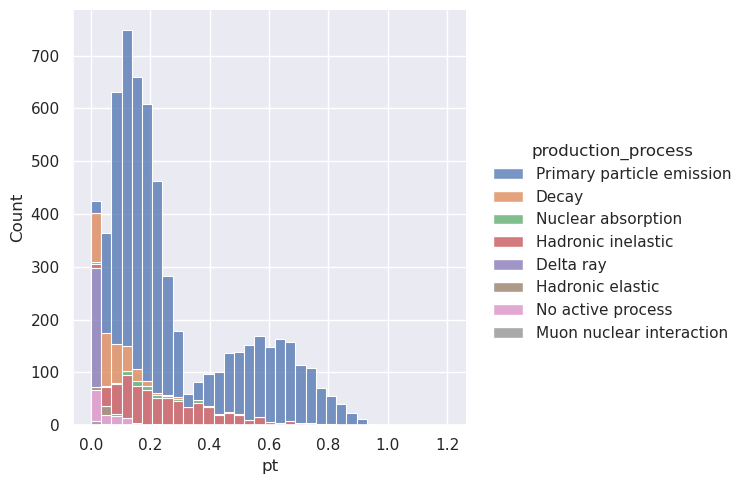

In [10]:
sns.set_theme()

sns.displot(momenta, x="pt", hue="production_process", multiple="stack")